In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [3]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    
    X = np.array([experiment - np.max(experiment) for experiment in X])
    X = np.array([experiment/-np.min(experiment) for experiment in X])

    y = np.round(y)
    y = y.astype(int)
    
    ## Let's shift each signal so that reference time matches for each signal
    mean_ref_time = int(y.mean())
    X = np.array([signal_cyclic_shift(signal, mean_ref_time - y[i]) for i, signal in enumerate(X, 0)])
    y = np.array([mean_ref_time]*len(y))

    return X, y

def get_freq_data(X, freq=1, start_point=384):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

def signal_cyclic_shift(signal, tau):
    signal_start = signal[:-tau]
    
    new_signal = np.concatenate([signal[-tau:], signal_start])
    
    return new_signal

In [4]:
X_origin, y_origin = get_data()

mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [73]:
import random

def generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=False):
    first_idx, second_idx = np.random.choice(X_origin.shape[0], 2, replace=False)
    first_impulse = X_origin[first_idx]
    second_impulse = X_origin[second_idx]
    
    first_ref_time = y_origin[first_idx]
    second_ref_time = y_origin[second_idx]
    
    
#     print("SHIFT:", tau)
#     print("BEFORE SHIFT:", first_ref_time, second_ref_time)
    ### Randomly choose what signal to shift
    if random.choice([True, False]):
        first_impulse = signal_cyclic_shift(first_impulse, tau)
        first_ref_time += tau
    else:
        second_impulse = signal_cyclic_shift(second_impulse, tau)
        second_ref_time += tau
    
#     print("AFTER SHIFT:", first_ref_time, second_ref_time)

    
    multi_impulse = first_impulse + second_impulse*alpha
    multi_impulse /= -np.min(multi_impulse)
    
    first_impulse_shifted = signal_cyclic_shift(first_impulse, mean_argmin - np.argmin(first_impulse))
    second_impulse_shifted = signal_cyclic_shift(second_impulse, mean_argmin - np.argmin(second_impulse))
    multi_impulse_shifted = signal_cyclic_shift(multi_impulse, mean_argmin - np.argmin(multi_impulse))

#     print(mean_argmin - np.argmin(multi_impulse))
    first_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    second_ref_time +=  mean_argmin - np.argmin(multi_impulse)
    
    if to_plot:
        plt.plot(first_impulse)
        plt.plot(second_impulse)
        plt.plot(multi_impulse_shifted)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
        
    return {'first_impulse': first_impulse_shifted,\
            'second_impulse': second_impulse_shifted,\
            'first_ref_time': first_ref_time,\
            'second_ref_time': second_ref_time,\
            'multi_impulse': multi_impulse_shifted}

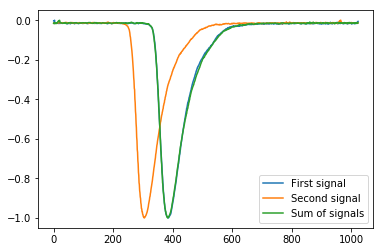

In [137]:
alpha_range = np.arange(1, 100, 0.1)
tau_range = np.arange(-100, 101, 1)

alpha = random.choice(alpha_range)
tau = random.choice(tau_range)
signal = generate_multi_signal(X_origin, y_origin, tau, alpha, to_plot=True)

In [138]:
signal

{'first_impulse': array([-0.0032648 , -0.00324525,  0.        , ..., -0.00651657,
        -0.00584536, -0.0032648 ]),
 'second_impulse': array([-0.01512209, -0.01267111, -0.01639712, ..., -0.01189155,
        -0.01192458, -0.01326568]),
 'first_ref_time': 245,
 'second_ref_time': 166,
 'multi_impulse': array([-0.01559929, -0.01311587, -0.01687054, ..., -0.01233497,
        -0.01238651, -0.01372807])}

In [143]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['first_ref_time']) ### We have alpha >= 1 so second_ref_time always will be close to 167,
                                           ### so we will predict first_ref_time
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [144]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])

alpha_range = np.arange(1, 100, 0.1)
tau_range = np.arange(-100, 101, 1)

In [145]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True)

X shape: (5000, 1024)
y shape: (5000,)


In [153]:
from sklearn.preprocessing import normalize

(array([450., 514., 509., 492., 511., 557., 506., 502., 494., 465.]),
 array([ 64. ,  84.4, 104.8, 125.2, 145.6, 166. , 186.4, 206.8, 227.2,
        247.6, 268. ]),
 <a list of 10 Patch objects>)

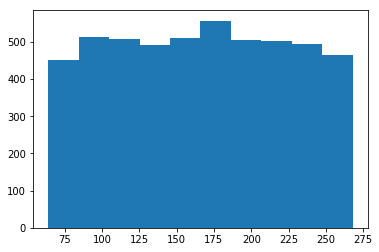

In [154]:
plt.hist(y)

In [155]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [156]:
def print_scores():
    for model in models:    
        model_name = type(model).__name__
        print("Regressor:", model_name)
    #         stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)

        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
        print("95% confindence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

In [157]:
import warnings
warnings.filterwarnings("ignore")

In [158]:
def get_models():
    huber_reg = HuberRegressor(epsilon= 4.927, alpha= 0.00759)
    ridge_reg = linear_model.Ridge(solver='saga', max_iter=5000, alpha= 1)
    lasso_reg = linear_model.Lasso(max_iter=4400, alpha=0.69, normalize=False)
    dt_reg = tree.DecisionTreeRegressor(min_samples_split=7, min_samples_leaf=9, min_weight_fraction_leaf=0.1, 
                                                                                                 max_features='sqrt')

    pa_reg = PassiveAggressiveRegressor(C=0.44, max_iter=2800, tol=2.4e-5)
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)
    return [huber_reg, ridge_reg, lasso_reg, dt_reg,  pa_reg, xgb_reg]

In [159]:
models = get_models()

In [160]:
print_scores()

Regressor: HuberRegressor
95% confindence interval:
r2 score: 0.23282 (+/- 0.07140)
mse score: 2542.11155 (+/- 194.85938)
mae score: 41.48888 (+/- 0.71885)
rmse score: 50.41012 (+/- 1.92990)
----------------------------------
Regressor: Ridge
95% confindence interval:
r2 score: 0.23221 (+/- 0.06432)
mse score: 2544.17363 (+/- 167.59748)
mae score: 41.59447 (+/- 0.45850)
rmse score: 50.43298 (+/- 1.65942)
----------------------------------
Regressor: Lasso
95% confindence interval:
r2 score: 0.03744 (+/- 0.00823)
mse score: 3191.37264 (+/- 143.22115)
mae score: 48.81448 (+/- 1.19913)
rmse score: 56.48870 (+/- 1.26426)
----------------------------------
Regressor: DecisionTreeRegressor
95% confindence interval:
r2 score: 0.74761 (+/- 0.06949)
mse score: 835.42682 (+/- 209.20964)
mae score: 21.33537 (+/- 2.96080)
rmse score: 28.85154 (+/- 3.47310)
----------------------------------
Regressor: PassiveAggressiveRegressor
95% confindence interval:
r2 score: -0.04711 (+/- 0.39044)
mse score: 

### Stacking

In [161]:
from mlxtend.regressor import StackingRegressor


In [ ]:
for i in range(len(models)):
    models = get_models()
    print("Metaregressor:", type(models[i]).__name__)

    stregr = StackingRegressor(regressors=models, meta_regressor=models[i])
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confindence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')

Metaregressor: HuberRegressor


In [ ]:
for i in range(len(models)):
    models = get_models()
    meta_reg = models[i]
    del models[i]
    
    stregr = StackingRegressor(regressors=models, meta_regressor=meta_reg)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    
    print("Metaregressor:", type(meta_reg).__name__)
    
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confindence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')